<a href="https://colab.research.google.com/github/zi-onion/24-2-ESAA/blob/main/09_02_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHAPTER 3 분류


## 3.1 MNIST

MNIST 데이터셋: 고등학생과 미국 인구 조사국 직원들이 손으로 쓴 70,000개의 작은 숫자 이미지

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1,as_frame=False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

사이킷런에서 읽어 들인 데이터들의 일반적인 딕셔너리 구조
* 데이터 셋을 설명하는 DESCR키
* 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data키
* 레이블 배열을 담은 target 키

In [ ]:
#mnist의 배열 살펴보기
X,y = mnist['data'],mnist['target']
X.shape

(70000, 784)

In [ ]:
y.shape

(70000,)

이미지가 70,000개, 각 이미지에는784개의 특성이 있음.

각  특성은 단순 0(흰)부터  255(검)까지의 픽셀 강도를 나타냄.

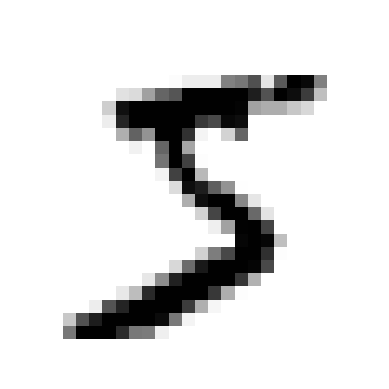

In [ ]:
#이미지 예시 확인
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

In [ ]:
# 레이블 확인
y[0]

'5'

레이블은 문자열이므로 정수로 변환.

In [ ]:
import numpy as np
y = y.astype(np.uint8)

In [ ]:
# 훈련 세트와 테스트 세트 나누기
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

mnist의 경우 이미 훈련(앞쪽 60000개)과 테스트(뒤쪽 10000개) 세트가 나뉘어 있는 데이터셋이다.

## 3.2  이진 분류기 훈련

In [ ]:
# 이진 분류기 예시: '5-감지기'
y_train_5 = (y_train == 5) # 5는 True, 다른 수는 모두 False
y_test_5 = (y_test == 5)

확률적 경사 하강법(SGD) 분류기로 훈련

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([some_digit])

array([ True])

-> 이미지가 5를 나타낸다고 추측.

## 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 측정

In [ ]:
# 교차 검증 구현
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train,y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds,y_train_folds)
  y_pred  =  clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct/len(y_pred))

0.95035
0.96035
0.9604


stratifiedKFoLd는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행함. 매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만듦. 그런 다음 올바른 예측의 수를 세어 정확한 예측의 비율을 출력함.

cross_val_score()함수로 폴드가 3개인 k-겹 교차 검증을 사용해 SGDCLassifier모델을 평가

In [ ]:
# SGD
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5,cv=3,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

-> 모든 교차 검증 폴드에 대해 정확도 (정확한 예측의 비율)가 95%이상

In [ ]:
# 더미 분류기
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self,X,y=None):
    return self
  def predict(self,X):
    return np.zeros((len(X),1),dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring='accuracy' )

array([0.91125, 0.90855, 0.90915])

-> 정확도가 90%이상

이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여줌. 특히 불균형 한 데이터셋을 다룰때 더욱 그러함.


### 3.3.2 오차 행렬

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5,cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

오차행렬의 행은 실제 클래스를, 열은 예측한 클래스를 나타냄.

-> 첫 번째 행은 음성클래스('5 아님')로 53,892개의 진짜 음성('5아님'으로 정확히 분류), 687개의 거짓 양성('5'라고 잘못 분류)으로 분류.

->두 번째 행은 양성클래스('5임')로 1,891개의 거짓 음성('5아님'으로 잘못 분류), 3,530개의 진짜 양성('5'라고 정확히 분류)으로 분류.


완벽한 분류기의 경우 오차행렬의 주대각선만 0이 아닌 값이 됨.

In [ ]:
y_train_perfect_predictions = y_train_5  # 완벽한 분류기일 경우
confusion_matrix(y_train_5,y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

* 정밀도: TP/TP+FP(양성 예측의 정확도)
* 재현율(민감도,진짜 양성 비율): TP/TP+FN(정확하게 감지한 양성의 비율)


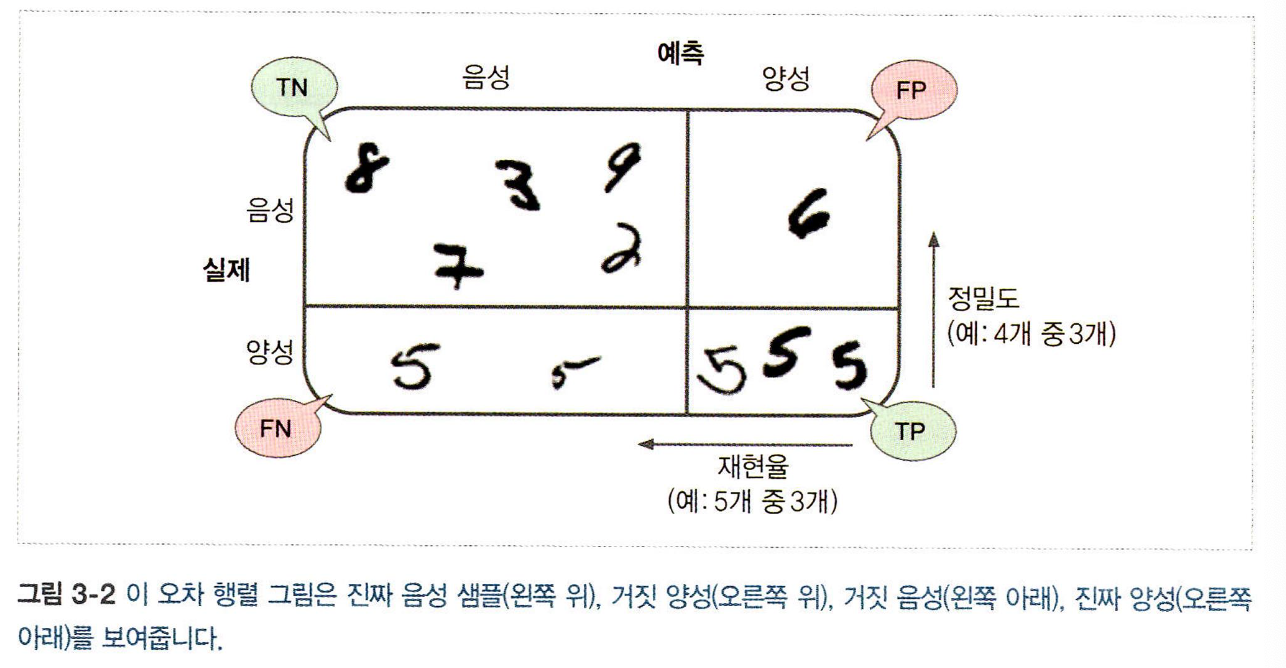

### 3.3.3 정밀도와 재현율

**정밀도**

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5,y_train_pred)

0.8370879772350012

**재현율**

In [ ]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

-> 정확도처럼 높지 않음.

**F1 점수**: 정밀도와 재현율의 조화 평균.
두 분류기를 비교할 때 유용
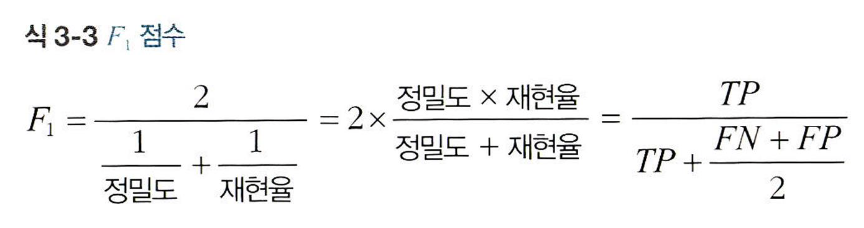

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높음.

F1 score가 높다고 항상 좋은 것은 아님. 상황에 따라 재현율 혹은 정밀도가 중요할 수도 있음.

### 3.3.4 정밀도/재현율 트레이드오프

**정밀도/재현율트레이드오프**: 정밀도를 올리면 재현율이 줄고 재현율을 올리면 정밀도가 주는 것.



SGD 분류기는 결정함수를 사용하여 각 샘플의 점수를 계산함.
결정 임곗값보다 크면 양성에, 작으면 음성 클래스에 할당함.

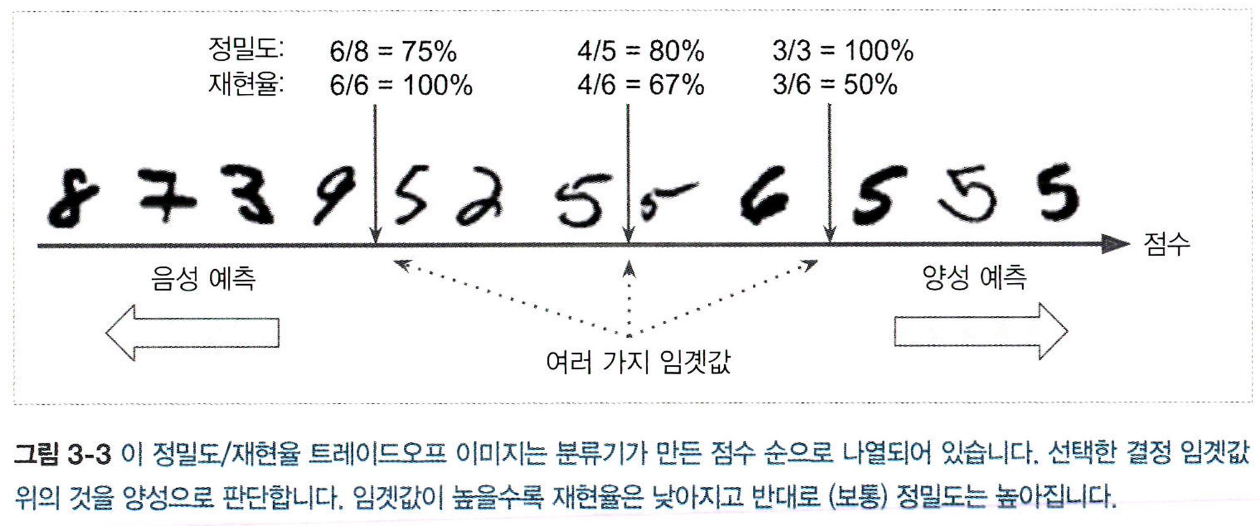

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
threshold=0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [ ]:
threshold=8000
y_some_digit_pred= (y_scores > threshold)
y_some_digit_pred

array([False])

적절한 임계값을 정하기 위해 예측 결정 점수를 반환받아야 함.

In [ ]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,
                             method='decision_function')

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions,recalls, thresholds =precision_recall_curve(y_train_5,y_scores)

맷플롯립을 통해 임곗값의 함수로 정밀도와 재현율을 그릴 수 있음.

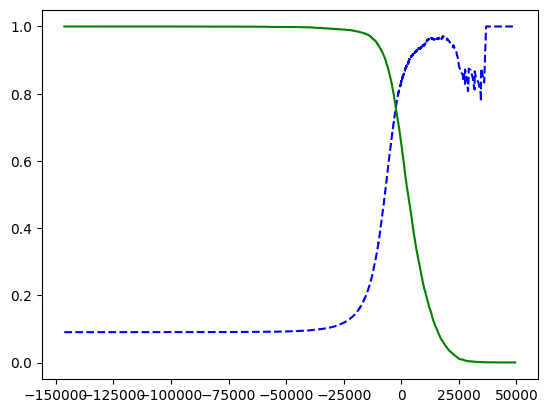

In [ ]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
  plt.plot(thresholds, precisions[:-1],'b--',label='정밀도')
  plt.plot(thresholds, recalls[:-1],'g-', label='재현율')
  [...] # 임곗값을 표시하고 범례, 축 이름, 그리드를 추가합니다.

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.9)]

In [ ]:
y_train_pred_90 =(y_scores>=threshold_90_precision)

In [ ]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [ ]:
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

-> 정확도가 90%인 분류기.

### 3.3.5 ROC 곡선
**수신기 조작 특성(ROC)**곡선: 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR=특이도)의 곡선

즉, 민감도(재현율)에 대한 1-특이도 그래프.

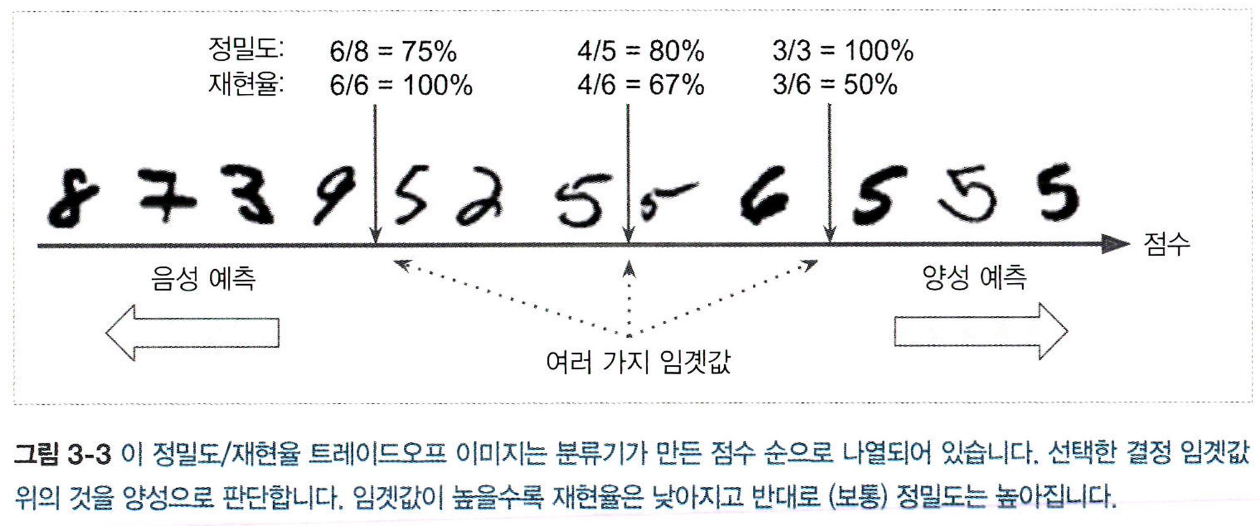

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5,y_scores)

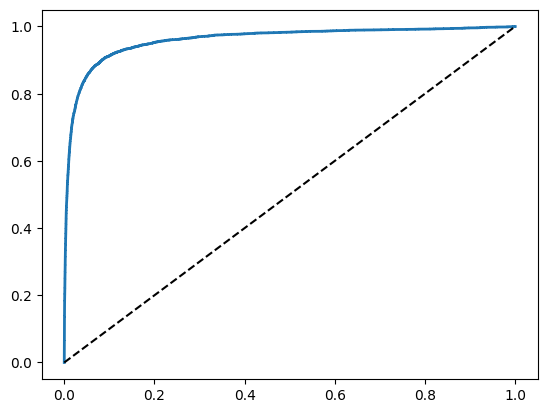

In [ ]:
def plot_roc_curve(fpr,tpr,label=None):
  plt.plot(fpr,tpr,linewidth=2,label=label)
  plt.plot([0,1],[0,1],'k--') # 대각 점선
  [...] # 축 이름, 그리드 추가

plot_roc_curve(fpr,tpr)
plt.show()

-> 재현율(TPR)이 높을수록 거짓 양성(FPR)이 늘어남.
점선은 완전한 랜덤 분류기의 ROC곡선을 의미.

좋은 분류기는 이 점선에서 최대한 멀리 떨어져 왼쪽 위 모서리에 있어야 함.

**곡선 아래의 면적(AUC)**을 측정하면 분류기 비교 가능.
완벽한분류기의 ROC의 AUC는 1, 완전랜덤분류기는 0.5.

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

 * 일반적인 법칙은 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 PR곡선을 사용하고 그렇지 않으면 ROC 곡선을 사용함.

Random Forest Classifier를 훈련시켜 SGDCLassifier의 ROC 곡선과 ROC AUC 점수를 비교

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf= RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train,y_train_5,cv=3,
                                    method='predict_proba')

-> roc_curve() 함수는 레이블과 점수를 기대. 점수 대신에 클래스 확률을 전달할 수 있음.


In [ ]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest= roc_curve(y_train_5,y_scores_forest)

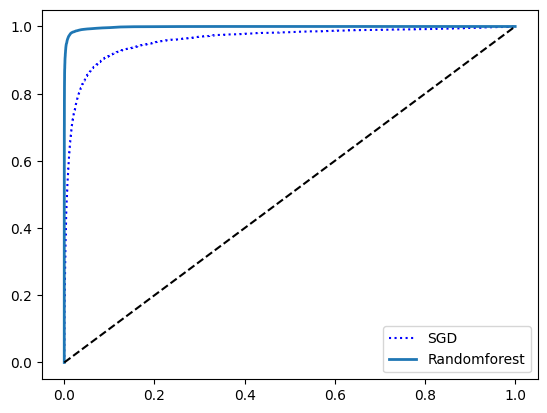

In [ ]:
plt.plot(fpr,tpr,'b:',label='SGD')
plot_roc_curve(fpr_forest,tpr_forest,'Randomforest')
plt.legend(loc='lower right')
plt.show()

-> RandomForestClassifier의 ROC곡선이 왼쪽 위 모서리에 더
가까워 SGDCLassifier보다 훨씬 좋아 보임

In [ ]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

-> ROC AUC 점수도 더 높음

## 3.4 다중 분류
**다중 분류기(다항 분류기)**: 둘 이상의 클래스를 구별가능

*  SGD 분류기,랜덤포레스트 분류기,나이브베이즈 분류기 등은 여러 개의 클래스를 직접 처리할 수 있으나, 로지스틱회귀나 서포트벡터머신 분류기 같 은 알고리즘은 이진 분류만 가능.


**OvR(OvA)**:각 분류기에서 결정 점수가 가장 높은 것을 클래스로 선택하는 전략

클래스가 N개라면 분류기는 N(N-1)/2 개 필요.

In [ ]:
from sklearn.svm import SVC
svm_clf=SVC()
svm_clf.fit(X_train[:2000], y_train[:2000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
some_digit_scores =svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 3.79297828,  0.72949369,  6.06184129,  8.29800527, -0.29383983,
         9.30157597,  1.74723215,  2.77365456,  7.20601456,  4.82245092]])

In [ ]:
np.argmax(some_digit_scores)

5

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
svm_clf.classes_[5]

5

사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 OneVsOneCLassifier나 OneVsRestClassifier를 사용.

In [ ]:
# SVC 기반으로 OvR전략 사용하는 다중 분류기
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train[:2000], y_train[:2000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

In [ ]:
#sgd를 훈련
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

-> 이 경우 sgd 자체가 다중 분류 할 수 있기에 OvR, OvO 필요 없음

In [ ]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

-> 클래스5의 점수 빼고, 대부분 점수가 큰 음수를 나타냄.

In [ ]:
# 교차 검증
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
# 입력 스케일 조정
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 3.5 에러 분석

에러의 종류 분석: 모델의 성능을 향상시킬 방법 중 하나.

In [ ]:
# 오차행렬
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

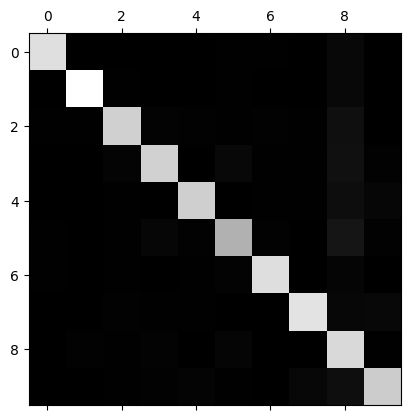

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
# 에러 비율을 비교
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

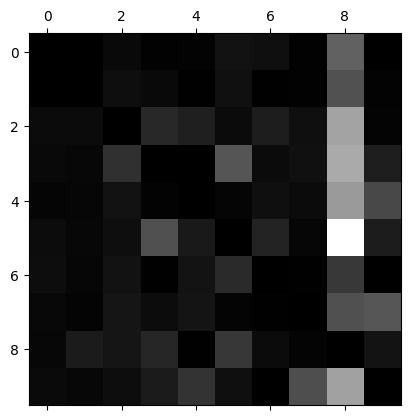

In [ ]:
# 주대각선만 0으로 채워서 그려보기
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

->클래스 8 열이 상당히 밝으므로 잘못 분류된 것을 암시함.
-> 3,5가 서로 혼동되고 있음.

In [ ]:
import matplotlib.pyplot as plt
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다.
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

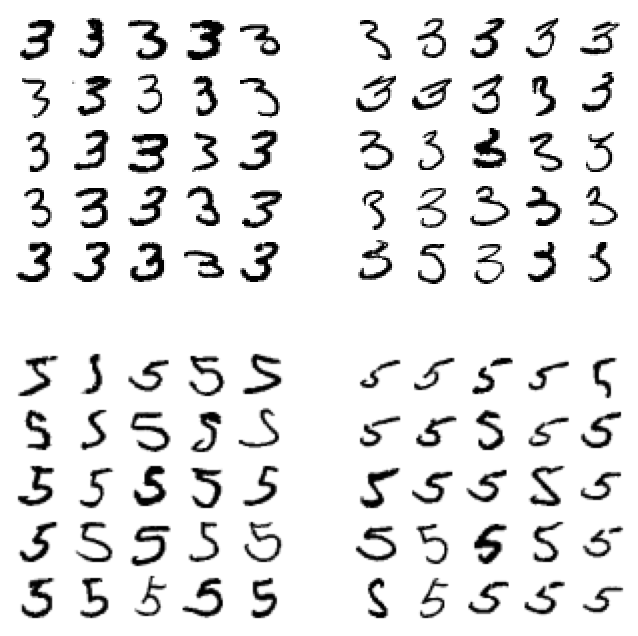

In [ ]:
# 3과 5의 샘플
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## 3.6 다중 레이블 분류
**다중 레이블 분류**시스템: 여러 개의 이진 꼬리표를 출력하는 분류 시스템

In [ ]:
#각 숫자 이미지에 두 개의 타깃 레이블이 담긴 Y_multilabel 배열 생성
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

-> 레이블 두 개 출력됨.

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

모든 레이블에 대한 F1점수의 평균 계산

-> 이 코드는 모든레이블의 가중치가 같다고 가정.

**지지도**를 가중치로 줄 수 있음.(average='weighted'설정)

##3.7 다중 출력 분류
**다중 출력 다중 클래스 분류(=다중 출력 분류)**: 한 레이블이 다중 클래스가 될 수 있는 것.(값 두 개 이상 가질 수 있는 것)


In [ ]:
# 데이터에 잡음 추가
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = plt.cm.binary,
               interpolation="nearest")
    plt.axis("off")

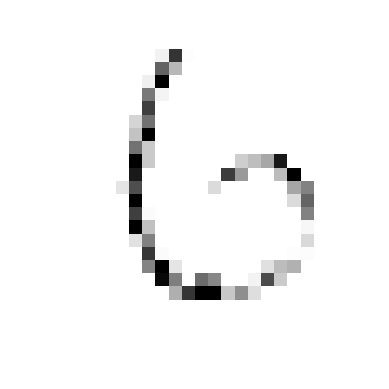

In [ ]:
some_index = 100
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)